In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from IPython.display import display
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from datetime import datetime
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('darkgrid')
#sns.set_context('poster')
%matplotlib inline

CRYPTO_FILES = [('ripple_price', 'rip'), ('bitcoin_price', 'btc'),
                ('ethereum_price', 'eth'), ('litecoin_price', 'ltc'),
                ('monero_price', 'mon'), ('nem_price', 'nem'),
                ('dash_price', 'dash')]

In [2]:
def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns in three formats.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
        xout (np.matrix): Returns matrix with centering/scaling (depending 
            on args), i.e., without index or column names.
    """
    dfs = []
    for file, name in files:
        path = 'cryptocurrencypricehistory//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj, np.matrix(xout)


def create_proportion_of_variation_df (eigvals):
    total_var = sum(eigvals)
    cols = ['component', 'eigenvalue', 'proportion', 'cumulative']
    df = pd.DataFrame(columns=cols)
    cum = 0
    for i, e in enumerate(eigvals):
        cum += e
        row = {'component':i + 1,
               'eigenvalue':e,
               'proportion':e/total_var,
               'cumulative':cum/total_var}
        df = df.append(row, ignore_index=True)
    df['component'] = df['component'].astype(int)
    df.set_index('component', drop=True, inplace=True)
    return df


def create_eigvec_df (eigvecs):
    """Create DataFrame of eigenvectors."""
    idx = [i + 1 for i in range(len(eigvecs))]
    df = pd.DataFrame(index=idx)
    for i, v in enumerate(eigvecs):
        df['V{}'.format(i + 1)] = v
    return df

In [3]:
# Init data and obtain covariance matrix.
df_returns_unadj, df_returns, X = load_returns_matrix(CRYPTO_FILES,
                                                      center=True, scale=True)
n, p = X.shape
C = np.cov(X, rowvar=False)  # covariance matrix
assert n == len(df_returns.index)
print('Number of returns in data: {}'.format(n))
df_returns.head()

Number of returns in data: 794


,rip,btc,eth,ltc,mon,nem,dash
Date,,,,,,,
2015-09-06,-0.291,-1.261,-1.125,-0.946,-0.783,-0.776,-0.828
2015-09-07,-0.314,-0.998,0.299,-0.803,-0.717,-0.739,-0.814
2015-09-08,-0.345,-0.998,0.427,-0.825,-0.684,-0.693,-0.852
2015-09-09,-0.353,-1.077,0.357,-0.915,-0.680,-0.772,-0.782
2015-09-10,-0.343,-1.157,-0.378,-0.979,-0.619,-0.766,-0.845


In [4]:
df_returns.head()

,rip,btc,eth,ltc,mon,nem,dash
Date,,,,,,,
2015-09-06,-0.291,-1.261,-1.125,-0.946,-0.783,-0.776,-0.828
2015-09-07,-0.314,-0.998,0.299,-0.803,-0.717,-0.739,-0.814
2015-09-08,-0.345,-0.998,0.427,-0.825,-0.684,-0.693,-0.852
2015-09-09,-0.353,-1.077,0.357,-0.915,-0.680,-0.772,-0.782
2015-09-10,-0.343,-1.157,-0.378,-0.979,-0.619,-0.766,-0.845


In [5]:
X.shape

(794, 7)

### Basic features of unstandardized price return data

In [6]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(df_returns_unadj.mean(axis=0))
print('S.D. of returns:')
display(df_returns_unadj.std(axis=0))
print('Cumulative return:')
display((df_returns_unadj + 1).prod(axis=0))
print('Correlation:')
df_returns.corr()

Price return statistics without centering/scaling:
Mean returns:


rip     0.395
btc     0.150
eth     0.410
ltc     0.173
mon     0.364
nem     0.585
dash    0.277
dtype: float64

S.D. of returns:


rip     1.468
btc     0.232
eth     0.836
ltc     0.475
mon     0.873
nem     1.190
dash    0.620
dtype: float64

Cumulative return:


rip     1.841e+43
btc     8.094e+41
eth     2.544e+71
ltc     7.702e+36
mon     3.682e+66
nem     1.561e+98
dash    3.883e+60
dtype: float64

Correlation:


,rip,btc,eth,ltc,mon,nem,dash
rip,1.000,0.305,0.325,0.694,0.066,0.630,0.037
btc,0.305,1.000,0.164,0.322,0.102,0.349,0.031
eth,0.325,0.164,1.000,0.192,0.171,0.361,0.470
ltc,0.694,0.322,0.192,1.000,0.044,0.428,0.018
mon,0.066,0.102,0.171,0.044,1.000,0.114,0.128
nem,0.630,0.349,0.361,0.428,0.114,1.000,0.133
dash,0.037,0.031,0.470,0.018,0.128,0.133,1.000


In [7]:
# Get SVD breakdown, cast into matrices.
U, s, V = np.linalg.svd(X)
U = np.matrix(U)  # n x n matrix
S = np.zeros((n, p)) 
S[:p, :p] = np.diag(s)
S = np.matrix(S)  # n x p matrix
V = np.matrix(V).T  # p x p matrix
eigvecs = [np.ravel(V[:,i]) for i in range(p)]

# Get eigenvalues through the singular values.
eigvals = [(s_**2)/(n - 1) for s_ in s]

In [8]:
# Reconstruct data matrix X and covariance matrix C using SVD properties.
# Check equality by looking at the norm of their difference.
Xreconstr = U*S*V.T
print('Norm[Xreconstr - X] = {:.2f}'.format(np.linalg.norm(Xreconstr - X)))

Creconstr = V*((S.T*S)/(n - 1))*V.T
print('Norm[Creconstr - C] = {:.2f}'.format(np.linalg.norm(Creconstr - C)))

# Get principal components (n-by-p matrix).
XV = X*V

Norm[Xreconstr - X] = 0.00
Norm[Creconstr - C] = 0.00


**Inner product should be 0 between all eigenvectors and principal components since they are orthogonal. Test this out for the first two eigenvectors and PCs.**

In [9]:
pc1, pc2 = np.ravel(XV[:, 0]), np.ravel(XV[:, 1])
v1, v2 = np.ravel(V[:, 0]), np.ravel(V[:, 1])
print('Inner product between 1st and 2nd eigenvectors: {:.2f}'.format(
      np.inner(v1, v2)))
print('Inner product between 1st and 2nd PCs: {:.2f}'.format(
      np.inner(pc1, pc2)))

Inner product between 1st and 2nd eigenvectors: 0.00
Inner product between 1st and 2nd PCs: 0.00


In [10]:
# Create tables for proportion of variation and eigenvectors.
df_variation_svd = create_proportion_of_variation_df(eigvals)
df_eigvec_svd = create_eigvec_df(eigvecs)

In [11]:
print('Eigenvectors obtained from SVD')
df_eigvec_svd

Eigenvectors obtained from SVD


,V1,V2,V3,V4,V5,V6,V7
1,0.517,-0.237,0.105,-0.286,0.015,-0.013,-0.764
2,0.334,-0.150,-0.305,0.867,0.095,-0.064,-0.091
3,0.358,0.508,0.204,0.007,-0.228,-0.712,0.118
4,0.455,-0.309,0.065,-0.226,0.611,-0.087,0.511
5,0.137,0.327,-0.880,-0.311,0.056,0.027,-0.012
6,0.487,-0.063,0.037,-0.044,-0.640,0.472,0.351
7,0.174,0.676,0.274,0.130,0.390,0.508,-0.103


In [12]:
# Print eigenvectors obtained using sklearn.
pca = PCA().fit(X)
sk_comp = pca.components_
print('Eigenvectors obtained from sklearn PCA.components_')
sk_comp.T

Eigenvectors obtained from sklearn PCA.components_


array([[ 0.517, -0.237, -0.105, -0.286, -0.015,  0.013,  0.764],
       [ 0.334, -0.15 ,  0.305,  0.867, -0.095,  0.064,  0.091],
       [ 0.358,  0.508, -0.204,  0.007,  0.228,  0.712, -0.118],
       [ 0.455, -0.309, -0.065, -0.226, -0.611,  0.087, -0.511],
       [ 0.137,  0.327,  0.88 , -0.311, -0.056, -0.027,  0.012],
       [ 0.487, -0.063, -0.037, -0.044,  0.64 , -0.472, -0.351],
       [ 0.174,  0.676, -0.274,  0.13 , -0.39 , -0.508,  0.103]])

### Variation Explained using Both Methods

Total variation should be equal to the sum of crypto's variances (7 cryptos * 1 unit variance = 7%).

In [13]:
print('Variation Explained using Eigenvalues from SVD')
df_variation_svd

Variation Explained using Eigenvalues from SVD


,eigenvalue,proportion,cumulative
component,,,
1,2.657,0.379,0.379
2,1.376,0.196,0.575
3,0.941,0.134,0.710
4,0.769,0.110,0.819
5,0.564,0.080,0.900
6,0.464,0.066,0.966
7,0.239,0.034,1.000


In [14]:
idx = [i + 1 for i in range(p)]
data = {'component': idx,
       'eigenvalue': pca.explained_variance_,
       'proportion': pca.explained_variance_ratio_}
df_variation_sk = pd.DataFrame(data)
df_variation_sk.set_index('component', drop=True, inplace=True)
print('Variation Explained using sklearn')
display(df_variation_sk)
print('Total variation: {:.2f}'.format(df_variation_sk['eigenvalue'].sum()))

Variation Explained using sklearn


,eigenvalue,proportion
component,,
1,2.657,0.379
2,1.376,0.196
3,0.941,0.134
4,0.769,0.110
5,0.564,0.080
6,0.464,0.066
7,0.239,0.034


Total variation: 7.01


### Comparing sklearn's PCA and SVD

The principal components retrieved using `sklearn` and SVD should be the same.

The following cell shows this is true for the first and second principal component.

In [15]:
# Get principal components using sklearn.
XReduced_sk = pca.transform(X)
assert XReduced_sk.shape == (n, p)

In [16]:
x1_reduced_sk = np.ravel(XReduced_sk[:,0])
x2_reduced_sk = np.ravel(XReduced_sk[:,1])

x1_reduced_diff = np.linalg.norm(x1_reduced_sk - pc1)
x2_reduced_diff = np.linalg.norm(x2_reduced_sk - pc2)

print("Norm of difference between sklearn's principal component and " \
     "component created using SVD:")
print('PC1: {:.2f}'.format(x1_reduced_diff))
print('PC2: {:.2f}'.format(x2_reduced_diff))

Norm of difference between sklearn's principal component and component created using SVD:
PC1: 0.00
PC2: 0.00


### Loadings

In [17]:
# Calc loadings and put into DataFrame.
loadings = eigvecs * np.sqrt(np.abs(eigvals))
idx = pd.Series([i + 1 for i in range(p)], name='component')

df_loadings = pd.DataFrame(loadings, columns=df_returns.columns, index=idx)
df_loadings

,rip,btc,eth,ltc,mon,nem,dash
component,,,,,,,
1,0.844,0.391,0.347,0.399,0.103,0.331,0.085
2,-0.386,-0.176,0.492,-0.271,0.245,-0.043,0.330
3,0.171,-0.358,0.198,0.057,-0.660,0.025,0.134
4,-0.466,1.017,0.007,-0.198,-0.233,-0.030,0.064
5,0.024,0.111,-0.221,0.536,0.042,-0.436,0.191
6,-0.021,-0.075,-0.691,-0.076,0.020,0.321,0.248
7,-1.245,-0.106,0.114,0.448,-0.009,0.239,-0.051


In [18]:
eigvecs

[array([ 0.517,  0.334,  0.358,  0.455,  0.137,  0.487,  0.174]),
 array([-0.237, -0.15 ,  0.508, -0.309,  0.327, -0.063,  0.676]),
 array([ 0.105, -0.305,  0.204,  0.065, -0.88 ,  0.037,  0.274]),
 array([-0.286,  0.867,  0.007, -0.226, -0.311, -0.044,  0.13 ]),
 array([ 0.015,  0.095, -0.228,  0.611,  0.056, -0.64 ,  0.39 ]),
 array([-0.013, -0.064, -0.712, -0.087,  0.027,  0.472,  0.508]),
 array([-0.764, -0.091,  0.118,  0.511, -0.012,  0.351, -0.103])]

In [19]:
df_eigvec_svd['V1'].sum(axis=0)

2.4618691572608493

## Yihang's code

In [20]:
small_df_std = df_returns
small_df_std.head()

,rip,btc,eth,ltc,mon,nem,dash
Date,,,,,,,
2015-09-06,-0.291,-1.261,-1.125,-0.946,-0.783,-0.776,-0.828
2015-09-07,-0.314,-0.998,0.299,-0.803,-0.717,-0.739,-0.814
2015-09-08,-0.345,-0.998,0.427,-0.825,-0.684,-0.693,-0.852
2015-09-09,-0.353,-1.077,0.357,-0.915,-0.680,-0.772,-0.782
2015-09-10,-0.343,-1.157,-0.378,-0.979,-0.619,-0.766,-0.845


In [21]:
cov = np.cov(small_df_std.values.T)     # covariance matrix
corr = np.corrcoef(df_returns_unadj.values.T)
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vals

array([ 2.657,  1.376,  0.239,  0.941,  0.769,  0.564,  0.464])

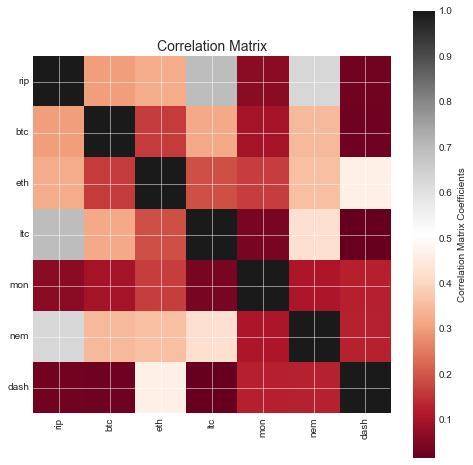

In [22]:
tickers = list(small_df_std.columns)

# Graph - Correlation matrix
plt.figure(figsize=(8,8))
plt.imshow(corr, cmap="RdGy", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers);

the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

In [23]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

cum_var_exp

array([  37.915,   57.55 ,   70.972,   81.939,   89.979,   96.592,  100.   ])

In [24]:
print(57.55 - 37.915)
print(70.972 - 57.55)
print(81.939 - 70.972)
print(89.979 - 81.939)
print(96.592 - 89.979)
print(100 - 96.592)

19.634999999999998
13.421999999999997
10.966999999999999
8.040000000000006
6.6129999999999995
3.4080000000000013


In [25]:
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs

[(2.6573777970786585,
  array([ 0.517,  0.334,  0.358,  0.455,  0.137,  0.487,  0.174])),
 (1.3761939225744024,
  array([ 0.237,  0.15 , -0.508,  0.309, -0.327,  0.063, -0.676])),
 (0.23884834723260553,
  array([ 0.764,  0.091, -0.118, -0.511,  0.012, -0.351,  0.103])),
 (0.9407062524264399,
  array([-0.105,  0.305, -0.204, -0.065,  0.88 , -0.037, -0.274])),
 (0.76868538699591216,
  array([-0.286,  0.867,  0.007, -0.226, -0.311, -0.044,  0.13 ])),
 (0.56351198020471516,
  array([-0.015, -0.095,  0.228, -0.611, -0.056,  0.64 , -0.39 ])),
 (0.46350355182270114,
  array([-0.013, -0.064, -0.712, -0.087,  0.027,  0.472,  0.508]))]

### Sorting Eigenpairs

In [26]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_vals_list = []
print('Eigenvalues in descending order:')
for i in eig_pairs:
    eig_vals_list.append(i[0])
    print(i[0])

Eigenvalues in descending order:
2.65737779708
1.37619392257
0.940706252426
0.768685386996
0.563511980205
0.463503551823
0.238848347233


In [27]:
matrix_Q = np.hstack((eig_pairs[0][1].reshape(7,1),
                      eig_pairs[1][1].reshape(7,1),
                      eig_pairs[2][1].reshape(7,1),
                      eig_pairs[3][1].reshape(7,1),
                      eig_pairs[4][1].reshape(7,1),
                      eig_pairs[5][1].reshape(7,1),
                      eig_pairs[6][1].reshape(7,1)))
#with desending order of eigen value 
matrix_Q

array([[ 0.517,  0.237, -0.105, -0.286, -0.015, -0.013,  0.764],
       [ 0.334,  0.15 ,  0.305,  0.867, -0.095, -0.064,  0.091],
       [ 0.358, -0.508, -0.204,  0.007,  0.228, -0.712, -0.118],
       [ 0.455,  0.309, -0.065, -0.226, -0.611, -0.087, -0.511],
       [ 0.137, -0.327,  0.88 , -0.311, -0.056,  0.027,  0.012],
       [ 0.487,  0.063, -0.037, -0.044,  0.64 ,  0.472, -0.351],
       [ 0.174, -0.676, -0.274,  0.13 , -0.39 ,  0.508,  0.103]])

## Loadings

Compute loadings A. May skip if you don't need to interpret PCs anyhow.
Loadings are eigenvectors normalized to respective eigenvalues: A value = V value * sqrt(L value)
Loadings are the covariances between variables and components.

Loadings=Orthonormal Eigenvectors⋅ Square root of (Absolute Eigen values)

In [28]:
eig_vals_sqrt = np.array([np.sqrt(eig_val) for eig_val in eig_vals_list])
eig_vals_sqrt

array([ 1.63 ,  1.173,  0.97 ,  0.877,  0.751,  0.681,  0.489])

In [29]:
ordered_col = (['rip','btc','ltc','mon','nem','dash','eth'])
loadings = pd.DataFrame(np.multiply(matrix_Q,eig_vals_sqrt)).T
loadings.columns = ordered_col
loadings

,rip,btc,ltc,mon,nem,dash,eth
0,0.844,0.544,0.583,0.742,0.224,0.793,0.284
1,0.278,0.176,-0.596,0.363,-0.383,0.074,-0.793
2,-0.102,0.296,-0.198,-0.063,0.853,-0.036,-0.266
3,-0.250,0.760,0.006,-0.198,-0.273,-0.039,0.114
4,-0.011,-0.071,0.171,-0.459,-0.042,0.481,-0.293
5,-0.009,-0.043,-0.485,-0.059,0.018,0.321,0.346
6,0.373,0.044,-0.058,-0.250,0.006,-0.171,0.051


In [30]:
sqr_loadings = loadings.applymap(np.square)
sqr_loadings

,rip,btc,ltc,mon,nem,dash,eth
0,7.116e-01,0.296,3.399e-01,0.550,5.002e-02,0.629,0.081
1,7.709e-02,0.031,3.546e-01,0.132,1.469e-01,0.006,0.629
2,1.034e-02,0.087,3.919e-02,0.004,7.279e-01,0.001,0.071
3,6.275e-02,0.578,3.784e-05,0.039,7.427e-02,0.001,0.013
4,1.239e-04,0.005,2.925e-02,0.211,1.757e-03,0.231,0.086
5,7.429e-05,0.002,2.350e-01,0.003,3.313e-04,0.103,0.119
6,1.393e-01,0.002,3.314e-03,0.062,3.500e-05,0.029,0.003


In [31]:
#make sure each row of square loadings table = eigenvalue
7.107e-01+0.296+3.395e-01+0.549+4.995e-02+0.628+0.081

2.65415

In [32]:
7.699e-02+0.031+3.542e-01+0.132+1.467e-01+0.006+0.628

1.3748900000000002

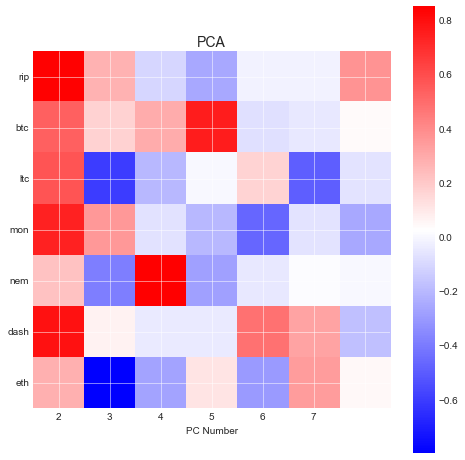

In [33]:
LL = np.multiply(matrix_Q,eig_vals_sqrt)
tickers = ordered_col
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(LL, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xticks(np.arange(len(tickers)), [1,2,3,4,5,6,7])
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

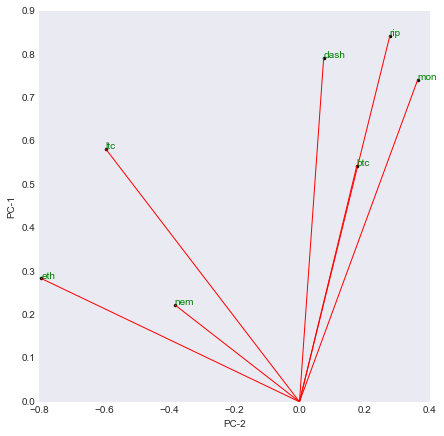

In [34]:
k1 = 1  # the last PC column in 'v' PCA matrix
k2 = 0  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(LL.shape[0]):
    x = LL[i,k1]
    y = LL[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="r")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    plt.text(x, y, tickers[i], color='g')
plt.xlabel("PC-" + str(k1+1))
plt.ylabel("PC-" + str(k2+1));

## Looking at energy (XLE)

In [35]:
XLE_FILES = [('COP_data', 'COP'), ('CVX_data', 'CVX'),
                ('EOG_data', 'EOG'), ('OXY_data', 'OXY'),
                ('PSX_data', 'PSX'), ('SLB_data', 'SLB'),
                ('XOM_data', 'XOM')]
def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns in three formats.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
        xout (np.matrix): Returns matrix with centering/scaling (depending 
            on args), i.e., without index or column names.
    """
    dfs = []
    for file, name in files:
        path = 'XLE//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close']).iloc[::-1]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj, np.matrix(xout)

In [36]:
df_returns_unadj, df_returns, X = load_returns_matrix(XLE_FILES,
                                                      center=True, scale=True)

In [37]:
df_returns.head()

,COP,CVX,EOG,OXY,PSX,SLB,XOM
Date,,,,,,,
2012-09-12,-0.170,0.174,0.301,-0.579,2.078,-0.204,0.383
2012-09-13,0.075,0.501,0.445,0.149,2.308,0.249,0.814
2012-09-14,0.229,0.737,0.840,0.610,2.155,0.810,1.155
2012-09-19,0.071,0.640,0.342,-0.188,0.662,0.068,0.707
2012-09-20,0.229,0.933,0.452,-0.067,1.317,0.179,1.097


In [38]:
XLE_df = df_returns_unadj
XLE_df_std = df_returns

cov = np.cov(XLE_df_std.values.T)     # covariance matrix
corr = np.corrcoef(XLE_df.values.T)   # correlation matrix
eig_vals, eig_vecs = np.linalg.eig(cov)

In [39]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_vals_list = []
print('Eigenvalues in descending order:')
for i in eig_pairs:
    eig_vals_list.append(i[0])
    print(i[0])

Eigenvalues in descending order:
4.39949467639
0.74475025426
0.677117981209
0.528119015865
0.310976461774
0.218834728165
0.130429104563


In [40]:
4.399,  0.13 ,  0.219,  0.311,  0.528,  0.745,  0.677
COP	CVX	EOG	OXY	PSX	SLB	XOM

COP, SLB, XOM,PSX,OXY, EOG,CVX

SyntaxError: invalid syntax (<ipython-input-40-e96c4331acee>, line 2)

In [ ]:
matrix_Q = np.hstack((eig_pairs[0][1].reshape(7,1),
                      eig_pairs[1][1].reshape(7,1),
                      eig_pairs[2][1].reshape(7,1),
                      eig_pairs[3][1].reshape(7,1),
                      eig_pairs[4][1].reshape(7,1),
                      eig_pairs[5][1].reshape(7,1),
                      eig_pairs[6][1].reshape(7,1)))
matrix_Q

In [ ]:
eig_vals_sqrt = np.array([np.sqrt(eig_val) for eig_val in eig_vals_list])
eig_vals_sqrt

ordered_col = (["COP","SLB","XOM","PSX","OXY","EOG","CVX"])
loadings = pd.DataFrame(np.multiply(matrix_Q,eig_vals_sqrt)).T
loadings.columns = ordered_col
loadings

In [ ]:
sqr_loadings = loadings.applymap(np.square)

LL = np.multiply(matrix_Q,eig_vals_sqrt)
tickers = ordered_col
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(LL, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
k1 = 1  # the last PC column in 'v' PCA matrix
k2 = 0  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(LL.shape[0]):
    x = LL[i,k1]
    y = LL[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="r")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    plt.text(x, y, tickers[i], color='g')
plt.xlabel("PC-" + str(k1+1))
plt.ylabel("PC-" + str(k2+1));

In [ ]:
XLE_df_std.head()